In [1]:
# --- Imports & setup ---
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

from scipy.stats import spearmanr, mannwhitneyu
from statsmodels.tsa.stattools import grangercausalitytests

# Create outputs folder
os.makedirs('outputs', exist_ok=True)


In [2]:
import pandas as pd

# --- Load historical trader data ---
hist = pd.read_csv("csv_files/historical_data.csv")  # replace with your file path
print("Hist shape:", hist.shape)
print("Hist columns:", hist.columns)

# --- Load sentiment data ---
sent = pd.read_csv("csv_files/fear_greed_index.csv")  # replace with your file path
print("Sentiment shape:", sent.shape)
print("Sentiment columns:", sent.columns)

# --- Preprocess sentiment data ---
sent.columns = [c.strip() for c in sent.columns]

# Parse date column
if "Date" in sent.columns:
    sent["date"] = pd.to_datetime(sent["Date"], errors="coerce").dt.date
elif "date" in sent.columns:
    sent["date"] = pd.to_datetime(sent["date"], errors="coerce").dt.date

# Identify classification column
possible_class_cols = [c for c in sent.columns if "class" in c.lower() or "fear" in c.lower() or "greed" in c.lower()]
if possible_class_cols:
    cls_col = possible_class_cols[0]
    sent["classification"] = sent[cls_col].astype(str).str.strip()
else:
    # Use numeric column if exists
    num_cols = [c for c in sent.columns if sent[c].dtype.kind in "if"]
    if len(num_cols) > 0:
        sent["classification"] = pd.cut(
            sent[num_cols[0]],
            bins=[-1,25,50,75,101],
            labels=["Extreme Fear","Fear","Neutral","Extreme Greed"]
        )
    else:
        raise ValueError("No classification or numeric column found in sentiment data!")

sent_use = sent[["date","classification"]].drop_duplicates()
print("Sentiment data ready. Sample:")
print(sent_use.head())


Hist shape: (32550, 16)
Hist columns: Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')
Sentiment shape: (2644, 4)
Sentiment columns: Index(['timestamp', 'value', 'classification', 'date'], dtype='object')
Sentiment data ready. Sample:
         date classification
0  2018-02-01           Fear
1  2018-02-02   Extreme Fear
2  2018-02-03           Fear
3  2018-02-04   Extreme Fear
4  2018-02-05   Extreme Fear


In [3]:
# --- Preprocess historical trades ---
# Parse Timestamp IST to datetime
hist['datetime'] = pd.to_datetime(hist['Timestamp IST'], format="%d-%m-%Y %H:%M", errors='coerce')

# Extract only the date for merging
hist['date'] = hist['datetime'].dt.date

# Drop any existing sentiment column
hist = hist.drop(columns=['sentiment_class'], errors='ignore')

# Merge with sentiment
merged = hist.merge(sent_use, how='left', on='date')

# Rename classification column to sentiment_class
merged = merged.rename(columns={'classification':'sentiment_class'})

# Fill missing values (forward/backward)
merged['sentiment_class'] = merged['sentiment_class'].fillna(method='ffill').fillna(method='bfill')

# Final check
print("✅ Final merged dataset shape:", merged.shape)
print("Unique sentiment_class values:", merged['sentiment_class'].unique())
print("Number of missing sentiment_class values:", merged['sentiment_class'].isna().sum())

# Sample view
merged.head()


✅ Final merged dataset shape: (32550, 19)
Unique sentiment_class values: ['Extreme Greed' 'Extreme Fear' 'Fear' 'Greed' 'Neutral']
Number of missing sentiment_class values: 0


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,datetime,date,sentiment_class
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02 22:50:00,2024-12-02,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02 22:50:00,2024-12-02,Extreme Greed


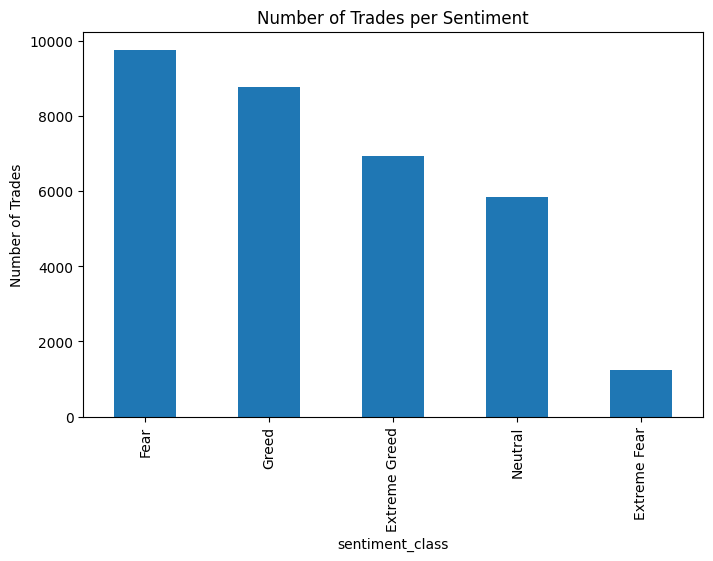

In [4]:
import matplotlib.pyplot as plt

trade_counts = merged['sentiment_class'].value_counts()
trade_counts.plot(kind='bar', figsize=(8,5), title='Number of Trades per Sentiment')
plt.ylabel('Number of Trades')
plt.savefig("./outputs/Number of Trades per Sentiment")
plt.show()


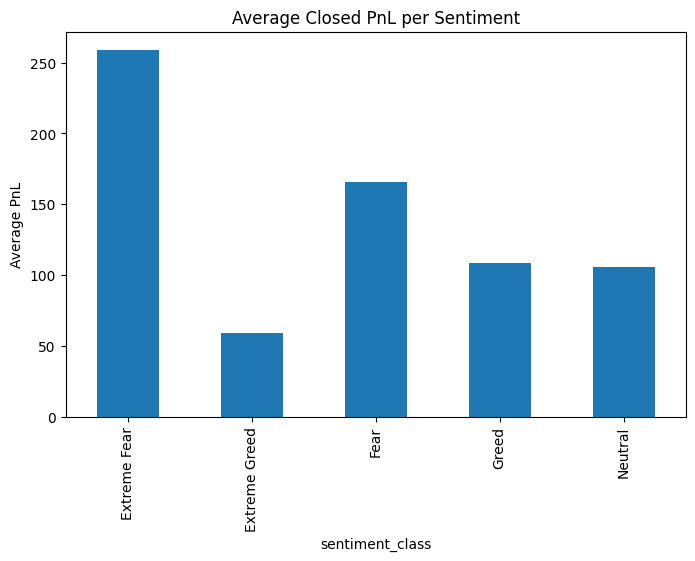

In [5]:
avg_pnl = merged.groupby('sentiment_class')['Closed PnL'].mean()
avg_pnl.plot(kind='bar', figsize=(8,5), title='Average Closed PnL per Sentiment')
plt.ylabel('Average PnL')
plt.savefig("./outputs/Average Closed PnL per Sentiment")
plt.show()



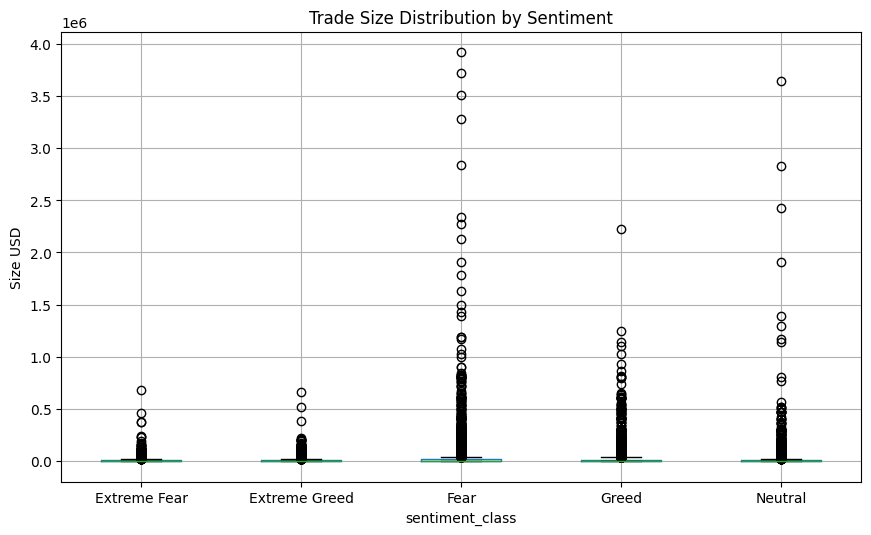

In [6]:
merged.boxplot(column='Size USD', by='sentiment_class', figsize=(10,6))
plt.title('Trade Size Distribution by Sentiment')
plt.suptitle('')
plt.ylabel('Size USD')
plt.savefig('./outputs/Trade Size Distribution by Sentiment')
plt.show()
